# Notebook Contents and Objectives:
This notebook contains mainly detail experiment on PyTorch model training part

In [ ]:
# !pip install -q transformers
# !pip install -q datasets
# !pip3 install --upgrade pip
# !pip install transformers[sentencepiece]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import json
from google.colab import data_table
import datasets
from datasets import Dataset
import json
# from thefuzz import process
# from thefuzz import fuzz
import re
import random
from typing import Any, List, Tuple

from PIL import Image
import torch
print("CUDA available:", torch.cuda.is_available())
# from donut import DonutModel
import transformers
from transformers import DonutProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel, BartConfig
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from torch.optim import Adam
from tqdm.auto import tqdm

CUDA available: False


# S-1: Initial dataset experiment
- We can skip these steps as we can take the processed dataset from `https://huggingface.co/indra-ami`

In [ ]:
train_path_main = '/content/drive/MyDrive/docVqa_dataset/train/train_v1.0.json'
# Open the JSON file
with open(train_path_main, 'r') as file:
  # Load the contents of the file into a dictionary
  data_train = json.load(file)

## Convert 'data' list into dataframe by passing into the dataframe
df_train = pd.DataFrame(data_train['data'])

## Making subset of the training dataframe
# df_sub = df_train.iloc[:100]
df_sub = df_train.iloc[:9]

In [ ]:
base_train_path = '/content/drive/MyDrive/docVqa_dataset/train'

In [ ]:
# Define a function to join the base path with the image path
def join_paths(image_path):
    return os.path.join(base_train_path, image_path)

# Apply the function to create a new column with the full image path
df_sub['full_path_image'] = df_sub['image'].apply(join_paths)


def extract_ocr_info(df, base_train_dir):

  dir_list = os.listdir(base_train_path)
  ocr_base_dir = os.path.join(base_train_path, dir_list[1])

  # Create empty lists for bounding boxes and word lists
  bbox_list = []
  word_list = []

  # Iterate over each row in the DataFrame
  for _, row in df.iterrows():

    # Construct the ocr_path for the row
    ocr_path = os.path.join(ocr_base_dir, row['ucsf_document_id'] + '_' + row['ucsf_document_page_no'] + '.json')

    # Open the json file and load the data
    with open(ocr_path, 'r') as f:
      ocr_json = json.load(f)

    # Extract the bounding boxes and word lists from the json data
    bbox_row = []
    word_row = []
    for i in ocr_json['recognitionResults'][0]['lines']:
      for j in i['words']:
        bbox_row.append(j['boundingBox'])
        word_row.append(j['text'])

    # Append the bbox and word lists to the global lists
    bbox_list.append(bbox_row)
    word_list.append(word_row)
  # Create new columns in the DataFrame to store the bbox and words lists
  df['bounding_boxes'] = bbox_list
  df['word_list'] = word_list

  df.drop(['questionId', 'image','ucsf_document_id', 'ucsf_document_page_no'], axis=1, inplace=True)

  # Return the updated DataFrame
  return df


df_sub_ocr = extract_ocr_info(df_sub, base_train_path)



## Convert dataframe into dataset object
hf_sub_ocr = Dataset.from_pandas(df_sub_ocr)


## Creating custom function
def add_ground_truth(hf_examples):

  images = hf_examples['full_path_image']
  questions = hf_examples['question']
  answers = hf_examples['answers']

  ground_truths = []
  for image, questions, answers in zip(images, questions, answers):
    # we need to escape " characters appearing in the query and/or answer
    questions = questions.replace('\\"', "") ## this was just one corrupt example (index 91 of training set)
    questions = re.sub(' +', ' ', questions)
    questions = questions.replace('"', '\\"')
    # let's create the ground truth string
    ground_truth_example = '{"gt_parses": ['
    for idx, answ in enumerate(answers):
      ans = answ.replace('"', '\"')
      ans = answ.replace('"', '\\"')
      ground_truth_example += '{"question" : "' + questions + '", "answer" : "' + ans + '"}'
      # add comma
      if idx != len(answers) - 1:
        ground_truth_example += ', '
    ground_truth_example += ']}'
    ground_truths.append(ground_truth_example)

  hf_examples['ground_truth'] = ground_truths

  return hf_examples



hf_sub_ocr_gt = hf_sub_ocr.map(add_ground_truth, batched=True)

<ipython-input-8-b00595b3fd87>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['full_path_image'] = df_sub['image'].apply(join_paths)
<ipython-input-8-b00595b3fd87>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bounding_boxes'] = bbox_list
<ipython-input-8-b00595b3fd87>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
model_checkpoint = "naver-clova-ix/donut-base"
max_length = 128
image_size = [1280, 960]


config = VisionEncoderDecoderConfig.from_pretrained(model_checkpoint)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

processor = DonutProcessor.from_pretrained(model_checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint, config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))


additional_tokens = ["<yes/>", "<no/>"]

add_tokens(additional_tokens)

In [ ]:
hf_sub_ocr_gt

Dataset({
    features: ['question', 'docId', 'answers', 'data_split', 'full_path_image', 'bounding_boxes', 'word_list', 'ground_truth'],
    num_rows: 9
})

In [ ]:
hf_sub_ocr_gt['ground_truth'][1]

'{"gt_parses": [{"question" : "what is the contact person name mentioned in letter?", "answer" : "P. Carter"}, {"question" : "what is the contact person name mentioned in letter?", "answer" : "p. carter"}]}'

In [ ]:
len(hf_sub_ocr_gt)

9

In [ ]:
type(hf_sub_ocr_gt)

datasets.arrow_dataset.Dataset

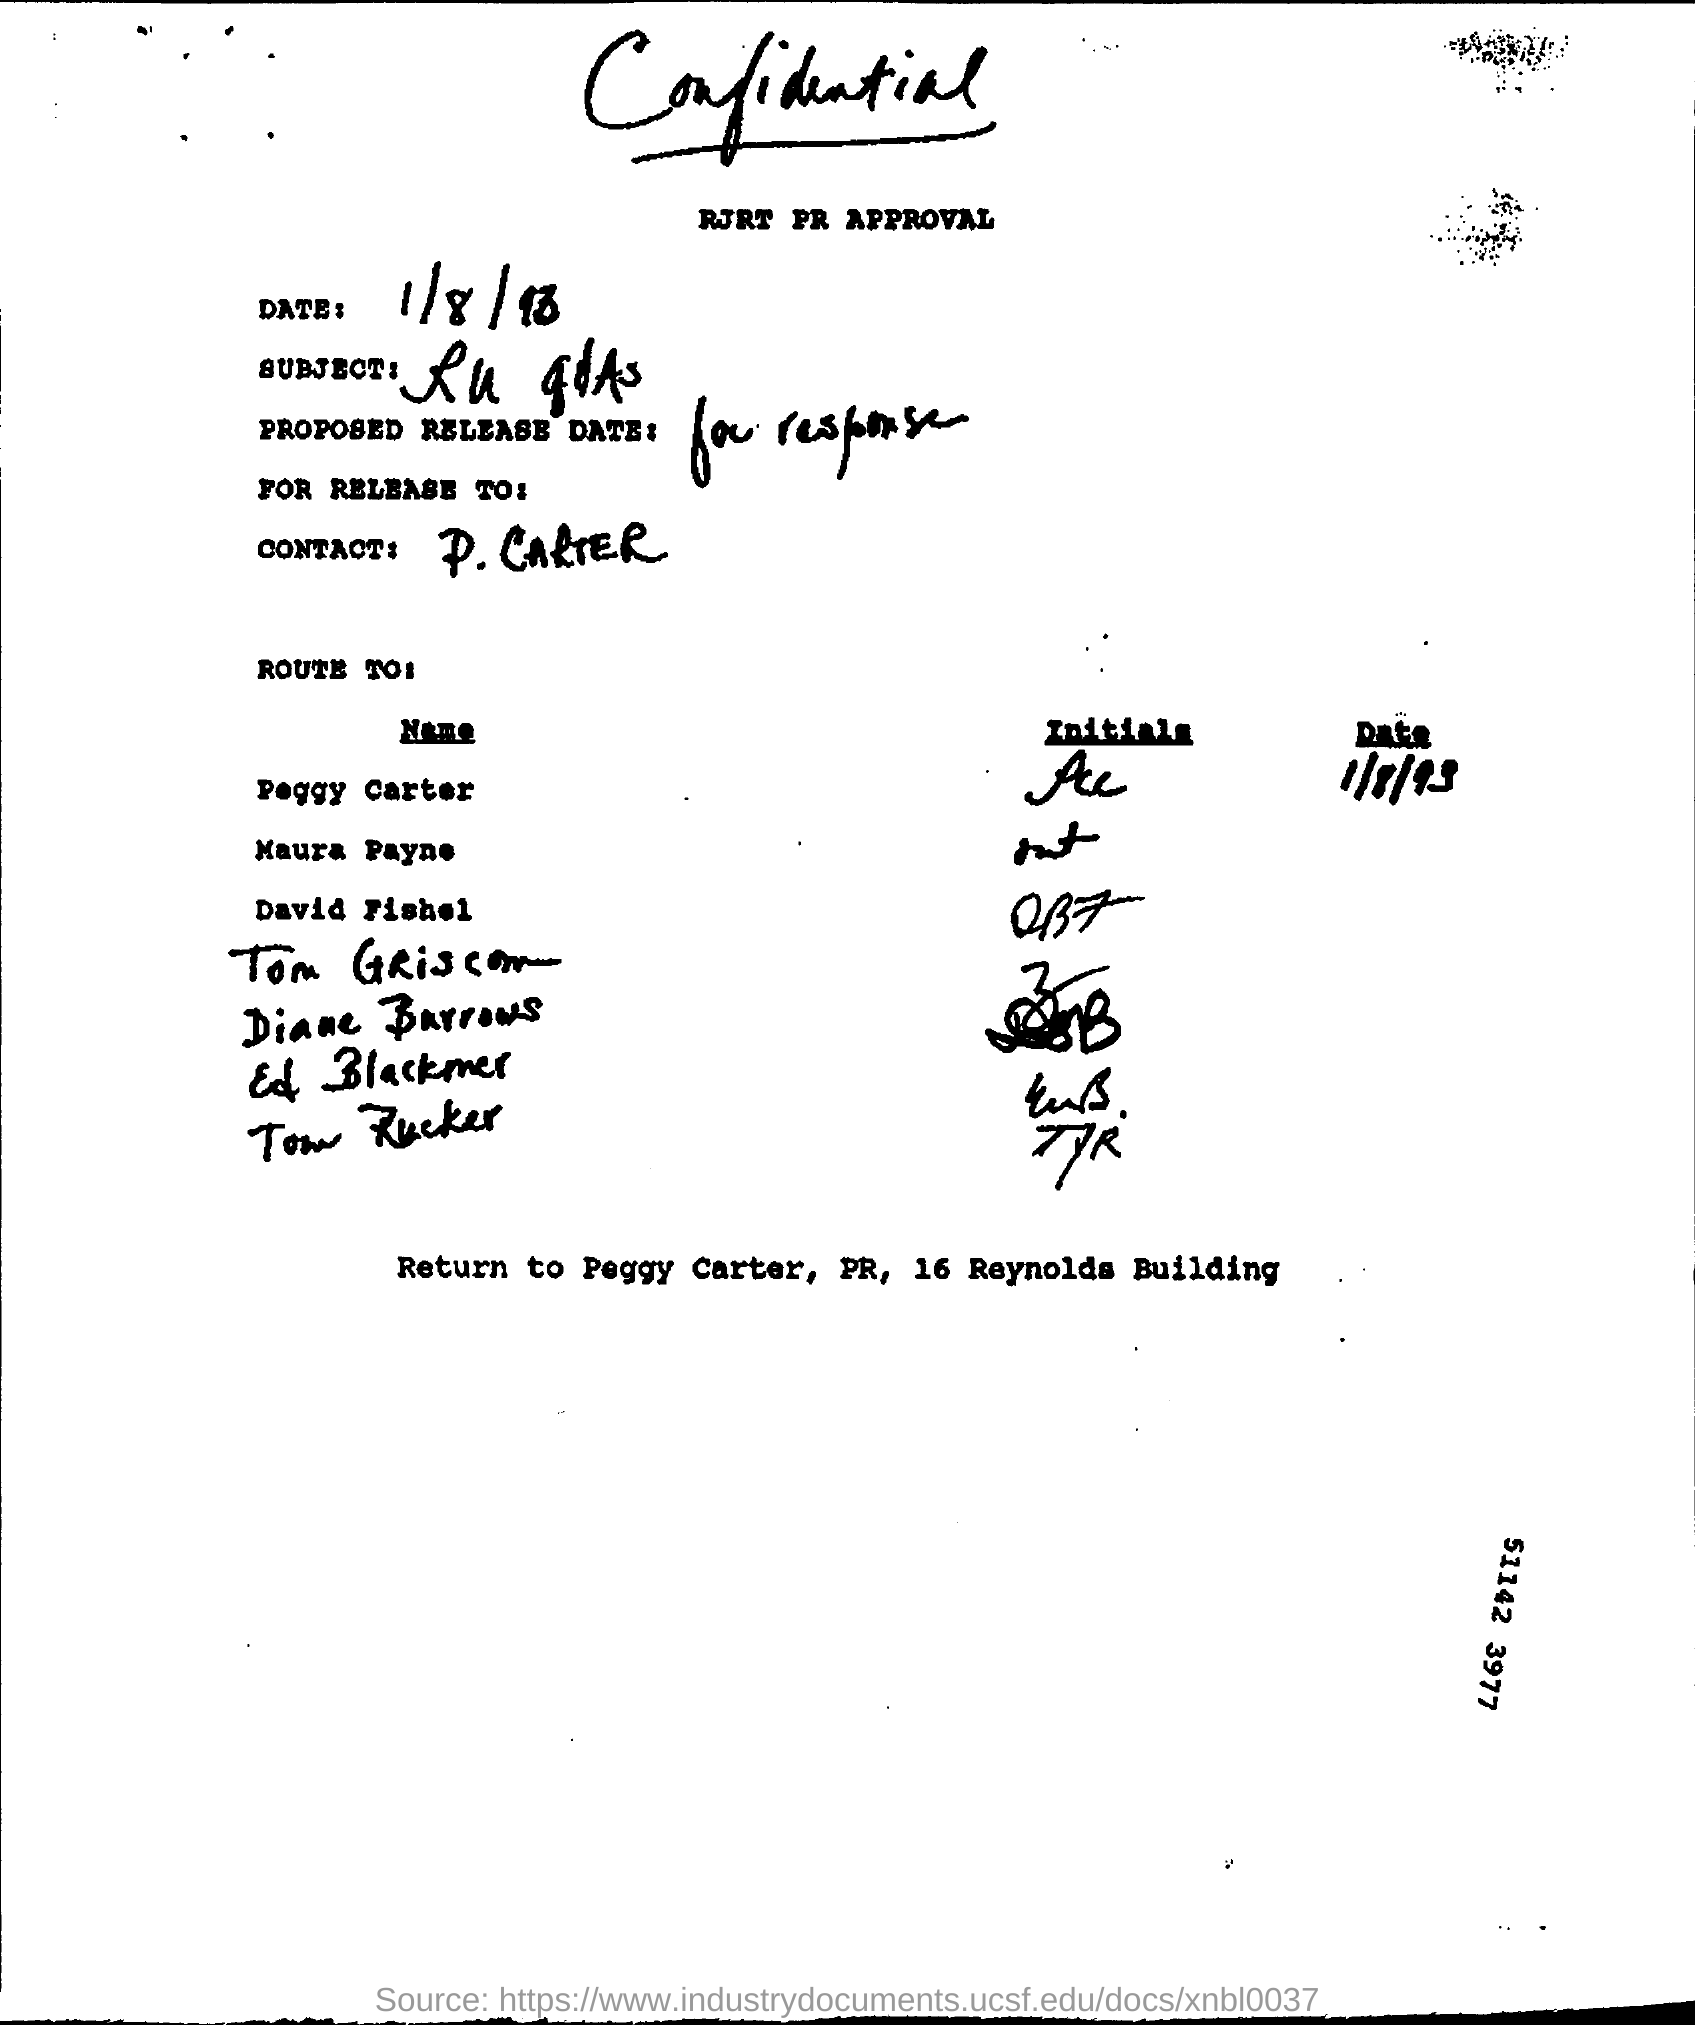

In [ ]:
Image.open(hf_sub_ocr_gt['full_path_image'][1]).convert("RGB")

In [ ]:
processor(Image.open(hf_sub_ocr_gt['full_path_image'][1]).convert("RGB")).pixel_values

[array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)]

In [ ]:
from torch.utils.data import Dataset

In [ ]:
added_tokens = []

## DonutDataset class inherits from the torch.utils.data.Dataset class and overrides its methods

class DonutDataset(Dataset):
  """
  DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
  Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
  and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
  Args:
      dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
      max_length: the max number of tokens for the target sequences
      split: whether to load "train", "validation" or "test" split
      ignore_id: ignore_index for torch.nn.CrossEntropyLoss
      task_start_token: the special token to be fed to the decoder to conduct the target task
      prompt_end_token: the special token at the end of the sequences
      sort_json_key: whether or not to sort the JSON keys
  """

  def __init__(
    self,
    dataset_name_or_path: str,    # Name of the dataset or the path containing image files and metadata.jsonl
    max_length: int,              # the maximum number of tokens for the target sequences/prompt
    # split: str = "train",
    ignore_id: int = -100,        # ignore_index for torch.nn.CrossEntropyLoss
    task_start_token: str = "<s>",   # The special token to be fed to the decoder to conduct the target task
    prompt_end_token: str = None,   # The special token at the end of the sequences
    sort_json_key: bool = True,       # Whether or not to sort the JSON keys
):
    super().__init__()

    self.max_length = max_length
    # self.split = split
    self.ignore_id = ignore_id
    self.task_start_token = task_start_token
    self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
    self.sort_json_key = sort_json_key

    self.dataset = dataset_name_or_path   ## **P1
    self.dataset_length = len(self.dataset)   # The length of the dataset is stored

    self.gt_token_sequences = []
    # list stores the ground truth (gt) token sequences, which are generated using the json2token() method for each sample in the dataset


    for sample in self.dataset:   # each sample is a dictionary
      ground_truth = json.loads(sample["ground_truth"])   # convert a string representation of ground_truth a JSON object
      if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
        assert isinstance(ground_truth["gt_parses"], list)
        gt_jsons = ground_truth["gt_parses"]
      else:
        assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
        gt_jsons = [ground_truth["gt_parse"]]

      self.gt_token_sequences.append(
          [
            self.json2token(
                gt_json,
                # update_special_tokens_for_json_key=self.split == "train",
                sort_json_key=self.sort_json_key,
              )
              + processor.tokenizer.eos_token
              for gt_json in gt_jsons  # load json from list of json
          ]
      )

    self.add_tokens([self.task_start_token, self.prompt_end_token])
    self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

  def json2token(self, obj: Any,  sort_json_key: bool = True):
      """
      Convert an ordered JSON object into a token sequence
      """
      if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
          return obj["text_sequence"]
        else:
          output = ""
          if sort_json_key:
            keys = sorted(obj.keys(), reverse=True)
          else:
            keys = obj.keys()
          for k in keys:
            # if update_special_tokens_for_json_key:
              # self.add_tokens([fr"", fr""])
            self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
            output += (
                fr"<s_{k}>"
                + self.json2token(obj[k], sort_json_key)
                + fr"</s_{k}>"
            )
          return output

      elif type(obj) == list:
          return r"<sep/>".join([self.json2token(item, sort_json_key) for item in obj])

      else:
          obj = str(obj)
          if f"<{obj}/>" in added_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
          return obj

  def add_tokens(self, list_of_tokens: List[str]):
      """
      Add special tokens to tokenizer and resize the token embeddings of the decoder
      """
      newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
      if newly_added_num > 0:
          model.decoder.resize_token_embeddings(len(processor.tokenizer))
          added_tokens.extend(list_of_tokens)

  def __len__(self) -> int:
      return self.dataset_length - 1

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
      """
      Load image from image_path of given dataset_path and convert into input_tensor and labels
      Convert gt data into input_ids (tokenized string)
      Returns:
          input_tensor : preprocessed image
          input_ids : tokenized gt_data
          labels : masked labels (model doesn't need to predict prompt and pad token)
      """
      sample = self.dataset[idx]

      # input_tensor
      # pixel_values = processor(Image.open(sample['full_path_image']).convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
      pixel_values = processor(Image.open(sample['full_path_image']).convert("RGB"), return_tensors="pt").pixel_values
      input_tensor = pixel_values.squeeze()

      # input_ids
      processed_parse = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
      input_ids = processor.tokenizer(
          processed_parse,
          add_special_tokens=False,
          max_length=self.max_length,
          padding="max_length",
          truncation=True,
          return_tensors="pt",
      )["input_ids"].squeeze(0)


      labels = input_ids.clone()
      labels[
          labels == processor.tokenizer.pad_token_id
      ] = self.ignore_id  # model doesn't need to predict pad token
      labels[
          : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
      ] = self.ignore_id  # model doesn't need to predict prompt (for VQA) e.g. here "<s_answer>"
      return input_tensor, input_ids, labels

      # if self.split == "train":
      #     labels = input_ids.clone()
      #     labels[
      #         labels == processor.tokenizer.pad_token_id
      #     ] = self.ignore_id  # model doesn't need to predict pad token
      #     labels[
      #         : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
      #     ] = self.ignore_id  # model doesn't need to predict prompt (for VQA) e.g. here "<s_answer>"
      #     return input_tensor, input_ids, labels
        ##  Here input_tensor = pixel value, input_ids = decoders prompt ids, labels = as per choice and remove the portion by -100 to make model understand
      # else:
      #     prompt_end_index = torch.nonzero(
      #         input_ids == self.prompt_end_token_id
      #     ).sum()  # return prompt end index instead of target output labels
      #     return input_tensor, input_ids, prompt_end_index, processed_parse


In [ ]:
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset_sub = DonutDataset(hf_sub_ocr_gt, max_length=max_length,
                             task_start_token="<s_docvqa_main>", prompt_end_token="<s_answer>",
                             sort_json_key=False,
                             )
# train_dataset = DonutDataset(hf_sub_ocr_gt, max_length=max_length,
#                              split="train", task_start_token="<s_docvqa_main>", prompt_end_token="<s_answer>",
#                              sort_json_key=False,
#                              )


In [ ]:
train_dataset_sub

In [ ]:
len(train_dataset_sub)

8

In [ ]:
# train_dataset_sub['question']      # *** very important error
## Note Although it is assumed that only we are getting only pixel values, decoder input ids and labels which we are passing inside the model
# but actually inside the model every column is passing

In [ ]:
train_dataset_sub[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57527, 27973, 52743, 48941, 44960, 40053, 35647, 25515, 54964, 36322,
   

In [ ]:
pixel_values2, decoder_input_ids2, labels2  = train_dataset_sub[2]

In [ ]:
pixel_values2.shape

torch.Size([3, 1280, 960])

In [ ]:
decoder_input_ids2.shape

torch.Size([128])

In [ ]:
labels2.shape

torch.Size([128])

In [ ]:
processor.decode(decoder_input_ids2)

"<s_question> Which corporation's letterhead is this?</s_question><s_answer> Brown & Williamson Tobacco Corporation</s_answer></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [ ]:
decoder_input_ids2

tensor([57527, 46193, 56931, 22964, 47459,  8888, 28431, 46192, 36322, 36294,
        52743, 54964, 36209, 57528, 57529, 39611, 46762, 39710, 20221, 49703,
        39571,  8342, 53498, 57530,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [ ]:
print(labels2)

tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100, 39611, 46762, 39710, 20221, 49703,
        39571,  8342, 53498, 57530,     2,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [ ]:
print(decoder_input_ids.tolist()[:-1]) ##

[57527, 46193, 56931, 22964, 47459, 8888, 28431, 46192, 36322, 36294, 52743, 54964, 36209, 57528, 57529, 39611, 46762, 39710, 20221, 49703, 39571, 8342, 53498, 57530, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
for decoder_input_id, label in zip(decoder_input_ids.tolist()[:-1], labels.tolist()[1:]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
W -100
hi -100
ch -100
corpora -100
tion -100
' -100
s -100
letter -100
head -100
is -100
this -100
? -100
</s_question> -100
<s_answer> Brown
Brown &
& Williams
Williams on
on To
To ba
ba cco
cco Corporation
Corporation </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -

# S-2: Model Training Phase

## Model Training when Batch Size = 1
- Note:
len(train_dataloader) and len(train_dataset) will have the same value. This is because len(train_dataloader) represents the number of batches in the dataloader, and when the batch size is 1, each sequence is treated as a separate batch.

### Create PyTorch DataLoaders
- 'num_workers': the number of worker processes to use for loading the data in parallel. It controls the parallelism of data loading and can significantly speed up the data loading process, especially when dealing with large datasets or performing complex data transformations.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader_sub = DataLoader(train_dataset_sub, batch_size=1)

In [ ]:
len(train_dataloader_sub)

8

In [ ]:
len(train_dataloader_sub.dataset)

8

In [ ]:
batch = next(iter(train_dataloader_sub))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape)
print(decoder_input_ids.shape)
print(labels.shape)

torch.Size([1, 3, 1280, 960])
torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
pixel_values

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])

In [ ]:
decoder_input_ids

tensor([[57527, 27973, 52743, 48941, 44960, 40053, 35647, 25515, 54964, 36322,
         36209, 57528, 57529,  1314, 27810, 47106,  4050, 57530,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  1314, 27810, 47106,  4050, 57530,     2,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [ ]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:30], labels[0].tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
what -100
is -100
the -100
date -100
mention -100
ed -100
in -100
this -100
letter -100
? -100
</s_question> -100
<s_answer> 1
1 /8
/8 /
/ 93
93 </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
len(processor.tokenizer)

57532

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s_answer>"])[0]
## Note:
# When training or generating captions, the decoder needs to know where to start generating the sequence.
# The decoder_start_token_id specifies the token ID that should be used as the initial input in the decoder.
# It acts as a signal to the decoder to indicate the beginning of the sequence.

In [ ]:
# list(model.parameters())

In [ ]:
## List of named parameter
# model.state_dict()

### 1: Batch Level Loss and Accuracy Check

In [ ]:
## Exp 1: Batch Level

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the loss function
# criterion = CrossEntropyLoss()

# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 2

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0   # Total correct across all batches in an epoch

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):
    # print(pixel_values, decoder_input_ids, labels)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)

    # Move tensors to the device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)  # torch.Size([1, 3, 1280, 960]) torch.Size([1, 128]) torch.Size([1, 128])
    # print(labels.size(0),labels.size(1)):     (1, 128)

    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, labels=labels)

    ## list(outputs)   op # ['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state']
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)
    # op- (torch.Size([]), torch.Size([1, 128, 57532]), torch.Size([1, 1200, 1024]))

    # outputs2 = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)    # output prediction buy not passsing labels
    ## list(outputs2)    # ['logits', 'past_key_values', 'encoder_last_hidden_state']

    loss = outputs.loss
    # print(f'Loss: {loss}', "||||||||" ,f'Extracting Single Value: {loss.item()}') # .item() collects loss value only from tensor

    total_loss += loss.item()
    # print(f"Total Cumulative Loss: {total_loss}")


    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the accuracy


    # Finding logits value
    logits = outputs.logits
    # print(logits)
    # tensor([[[17.3780, -0.6676, 26.5443,  ..., -1.2713,  0.2468, -0.5575],....
    # [31.8875, -1.1383, 43.7016,  ..., -1.0564,  0.6989,  0.7606]]],grad_fn=<UnsafeViewBackward0>)

    ## Note : What is logits here?
    # Ans: Logits are predicted output logits or scores generated by the model.
    # Logits are raw, unnormalized values that represent the model's predictions for each class or category
    # For these NLP task logits is predicted unnormalized score for each token

    # print(logits.shape, logits.ndim)   # torch.Size([1, 128, 57532]) and 3

    predictions = logits.argmax(dim=-1) # index value of maximum score for each token

    # print(predictions, predictions.shape)   # torch.Size([1, 128])
    # print(labels == torch.argmax(logits,dim = -1) or predictions)   ## Result is Binary Tensor contain True and False
    ## op- tensor([[False, False, False,.......False,False, False,  True,  True, False,  True, False]])
    # .sum() will give the number of corrected True value and op will be like e.g tensor(3)
    # .item() will take the value part inside the tensor e.g 3

    correct = (predictions == labels).sum().item()    ## Number of correct in each row

    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch


  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value
  avg_epoch_accuracy_batch_level = total_correct / len(train_dataloader_sub) # average per epoch accuracy at batch level
  # Here as batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss: {avg_epoch_loss_batch_level:.4f} ::::  Training Accuracy: {avg_epoch_accuracy_batch_level:.2f}%")


Epoch 1/1


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 4.9464 ::::  Training Accuracy: 2.38%


In [ ]:
outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape

(torch.Size([]), torch.Size([1, 128, 57532]), torch.Size([1, 1200, 1024]))

In [ ]:
logits

tensor([[[-5.8081,  0.0793,  5.4949,  ..., -0.1174,  3.4519,  0.0478],
         [ 1.5344, -0.2896, 16.6696,  ..., -1.1553,  2.4545,  0.0850],
         [-0.9175, -0.2867, 17.8879,  ..., -3.0757,  2.9916, -0.5715],
         ...,
         [-5.5918, -0.1829,  6.6283,  ..., -3.2614,  1.8385, -0.7155],
         [ 3.1519, -0.4909, 15.4247,  ..., -2.3077,  1.1602, -0.2210],
         [ 2.2861, -0.4273, 13.8019,  ..., -2.1560,  0.7341,  0.5271]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
logits.shape, logits.ndim

(torch.Size([1, 128, 57532]), 3)

In [ ]:
torch.argmax(logits)

tensor(676880)

In [ ]:
torch.argmax(logits,dim = -1), torch.argmax(logits,dim = -1).shape

(tensor([[ 5941, 56939, 42990, 42990, 42990, 42990, 42990, 42990, 16962, 42990,
          42990, 44028, 39539, 49449, 57530, 42990, 33364,  5941, 33364, 57530,
           2509, 15973, 33427, 11779, 11779, 57454, 11779,     3,  2509,  2099,
          19817, 19817, 13939, 25119,  2099,     3,     3,  2509, 13939,     3,
          11779,     3,  2099,  2509,  2509, 18541,     3,  5768,  8665, 19429,
              3,     3, 25519,     3,     3, 57454, 20710, 17391, 20710,     3,
              3,     3,     3, 33819, 19429,     3,     3,     3,     3,     3,
              3, 17391,     3,     3,  5217,     3, 17391,  1454,  1454,     3,
              3,  1454,  1454,     3,  1454,     3,     3,     3,     3,     3,
              3, 41510,  1454,     3,  1454,  1454,     3,     3, 15973,     3,
           1454,     3,     3,  1454, 26008, 13939,     3, 18438,  1454, 45805,
              3,     3,     3,   611, 42990,  1454,     3, 42990,     3, 42990,
              3,     3, 42990, 42990, 42

In [ ]:
labels, labels.shape, labels.size(0), labels.size(1)

(tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          18699, 44028, 35815, 49449, 57530,     2,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -

In [ ]:
labels == torch.argmax(logits,dim = -1)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [ ]:
(labels == torch.argmax(logits,dim = -1)).sum(), (labels == torch.argmax(logits,dim = -1)).sum().item()   ## correct

(tensor(3), 3)

In [ ]:
total_correct, len(train_dataloader_sub), (total_correct/len(train_dataloader_sub))

#### Note: Inside Model
- The loss will not be included in the output when labels are not passed because the loss value can only be computed when there are ground truth labels available for comparison. The loss is a measure of the discrepancy between the model's predictions and the desired outputs.

- In the context of question answering or any other supervised learning task, the model learns by comparing its predicted outputs with the provided labels during training. The loss function quantifies the difference between the predicted outputs (logits) and the ground truth labels. By optimizing the loss, the model adjusts its parameters to improve its predictions.

- When you omit the labels parameter in the forward pass (model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)), the model does not have the ground truth information to compute the loss. As a result, the loss value is not included in the output.

- It's important to note that during training, it is necessary to provide the labels for calculating the loss and updating the model's parameters. However, during inference or evaluation, when you only want the model's predictions, you can omit the labels as they are not required for generating the outputs.

#### Imp NOTE: What to divide for finding Average loss

1.   List item


** Avg Loss:

- To find the average epoch loss, you can divide the total loss by the number of batches or iterations in an epoch, which is typically represented by len(train_dataloader).

- The reason behind this division is to normalize the loss value based on the number of samples or batches in the dataset. When training a model, the loss is computed for each batch, and the goal is to optimize the model's parameters based on the average loss across the entire dataset. Dividing the total loss by the number of batches provides this average loss value.

- By dividing by len(train_dataloader), you are essentially calculating the average loss per batch. This allows you to compare the loss values across different batch sizes or datasets and track the model's performance more consistently.

- Note that dividing by the number of batches is just one way to calculate the average loss. In some cases, you may want to consider dividing by the total number of samples in the dataset (len(train_dataset)) instead of the number of batches. It depends on your specific requirements and the context of your training process.

-----------------------------------------------------------------------
### Meaning to divide by len(train_dataloader) and len(train_dataset)?
- total_loss: Total loss across all batches in an epoch
- num_batches: Number of batches in an epoch (i.e., len(train_dataloader))
- num_samples: Number of samples in the dataset (i.e., len(train_dataset))

```
To understand the mathematical difference,
let's consider a hypothetical example
where total_loss is 10, num_batches is 5, and num_samples is 100.

1. Dividing by num_batches:
average_loss_per_batch = total_loss / num_batches

average_loss_per_batch = 10 / 5 = 2
*** Dividing by num_batches gives you the 'Average loss per batch'

2. Dividing by num_samples:
average_loss_per_sample = total_loss / num_samples

average_loss_per_sample = 10 / 100 = 0.1
*** Dividing by num_samples gives you the 'Average loss per sample'
```
- The former provides an indication of how the model is performing on each batch of the training data, while the latter gives you a measure of the average loss across the entire dataset.

- Typically, during training, it is more common to monitor and report the average loss per batch (average_loss_per_batch) as it gives you a more granular view of the training progress. However, the choice of which division to use ultimately depends on your specific requirements and the context of your training process.

#### Imp NOTE: What to divide for finding Average accuracy

- When calculating the average epoch accuracy, you have a few options for the denominator: total_samples/token level, len(train_dataloader), or len(train_dataset). Let's examine the mathematical differences and implications of each option.

```
1. Dividing by total_samples: Token Level

average_accuracy = total_correct / total_samples

- Suppose you have total_correct as 80 and total_samples as 100.

* average_accuracy = 80 / 100 = 0.8

Dividing by total_samples/tokens gives you the average accuracy at token level.
It represents how well the model is performing on average across all the token length.
```
```
2. Dividing by len(train_dataloader) i.e Batch Level

average_accuracy = total_correct / len(train_dataloader)

Example:
Assume you have total_correct as 80 and len(train_dataloader) as 5.

* average_accuracy = 80 / 5 = 16

Dividing by len(train_dataloader) provides the average accuracy per batch.
It gives you a measure of how well the model is performing on each batch of
the training data.
```
```
Dividing by len(train_dataset): On overall datasets or datapoints

average_accuracy = total_correct / len(train_dataset)

Example:
Consider total_correct as 80 and len(train_dataset) as 1000. Then,

* average_accuracy = 80 / 1000 = 0.08

Dividing by len(train_dataset) calculates the average accuracy per sample in the dataset.
It represents the overall performance of the model across the entire dataset.
```


### 2: Sample i.e. labels.size(0) Level Loss and Accuracy Check

In [ ]:
## Exp 2: Sample level Accuracy Check which is same as accuracy based on whole dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the loss function
# criterion = CrossEntropyLoss()

# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 1

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0
  total_samples = 0

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):
    # print(pixel_values, decoder_input_ids, labels)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)
    # Move tensors to the device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)  # torch.Size([1, 3, 1280, 960]) torch.Size([1, 128]) torch.Size([1, 128])

    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, labels=labels)

    ## list(outputs)   op # ['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state']
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)
    # op- (torch.Size([]), torch.Size([1, 128, 57532]), torch.Size([1, 1200, 1024]))

    # outputs2 = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)    # output prediction buy not passsing labels
    ## list(outputs2)    # ['logits', 'past_key_values', 'encoder_last_hidden_state']

    loss = outputs.loss
    # print(f'Loss: {loss}', "||||||||" ,f'Extracting Single Value: {loss.item()}') # .item() collects loss value only from tensor

    total_loss += loss.item()
    # print(f"Total Cumulative Loss: {total_loss}")


    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the accuracy
    total_samples += labels.size(0)     # labels.size(0) = 1

    # Finding logits value
    logits = outputs.logits
    # print(logits)
    # tensor([[[17.3780, -0.6676, 26.5443,  ..., -1.2713,  0.2468, -0.5575],....
    # [31.8875, -1.1383, 43.7016,  ..., -1.0564,  0.6989,  0.7606]]],grad_fn=<UnsafeViewBackward0>)

    ## Note : What is logits here?
    # Ans: Logits are predicted output logits or scores generated by the model.
    # Logits are raw, unnormalized values that represent the model's predictions for each class or category
    # For these NLP task logits is predicted unnormalized score for each token

    # print(logits.shape, logits.ndim)   # torch.Size([1, 128, 57532]) and 3

    predictions = logits.argmax(dim=-1) # index value of maximum score for each token

    # print(predictions, predictions.shape)   # torch.Size([1, 128])
    # print(labels == torch.argmax(logits,dim = -1) or predictions)   ## Result is Binary Tensor contain True and False
    ## op- tensor([[False, False, False,.......False,False, False,  True,  True, False,  True, False]])
    # .sum() will give the number of corrected True value and op will be like e.g tensor(3)
    # .item() will take the value part inside the tensor e.g 3

    correct = (predictions == labels).sum().item()    ## Number of correct in each row

    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch


  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value
  avg_epoch_accuracy_sample_level = total_correct / total_samples # average per epoch accuracy at based on number of data point
  # Here as batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss: {avg_epoch_loss_batch_level:.4f} ::::  Training Accuracy: {avg_epoch_accuracy_sample_level:.2f}%")



Epoch 1/1


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9575 ::::  Training Accuracy: 5.75%


In [ ]:
total_correct, total_samples, (total_correct/total_samples)

(46, 8)

### 3: Token Level Loss and Accuracy Check

In [ ]:
## Exp 3: Token level Accuracy Check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the loss function
# criterion = CrossEntropyLoss()

# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 1

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0
  total_samples_token_level = 0

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):
    # print(pixel_values, decoder_input_ids, labels)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)
    # Move tensors to the device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)  # torch.Size([1, 3, 1280, 960]) torch.Size([1, 128]) torch.Size([1, 128])

    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, labels=labels)

    ## list(outputs)   op # ['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state']
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)
    # op- (torch.Size([]), torch.Size([1, 128, 57532]), torch.Size([1, 1200, 1024]))

    # outputs2 = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)    # output prediction buy not passsing labels
    ## list(outputs2)    # ['logits', 'past_key_values', 'encoder_last_hidden_state']

    loss = outputs.loss
    # print(f'Loss: {loss}', "||||||||" ,f'Extracting Single Value: {loss.item()}') # .item() collects loss value only from tensor

    total_loss += loss.item()
    # print(f"Total Cumulative Loss: {total_loss}")


    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the accuracy

    total_samples_token_level += labels.size(0) * labels.size(1)     # labels.size(0) = 1  and labels.size(1) = 128

    # Finding logits value
    logits = outputs.logits
    # print(logits)
    # tensor([[[17.3780, -0.6676, 26.5443,  ..., -1.2713,  0.2468, -0.5575],....
    # [31.8875, -1.1383, 43.7016,  ..., -1.0564,  0.6989,  0.7606]]],grad_fn=<UnsafeViewBackward0>)

    ## Note : What is logits here?
    # Ans: Logits are predicted output logits or scores generated by the model.
    # Logits are raw, unnormalized values that represent the model's predictions for each class or category
    # For these NLP task logits is predicted unnormalized score for each token

    # print(logits.shape, logits.ndim)   # torch.Size([1, 128, 57532]) and 3

    predictions = logits.argmax(dim=-1) # index value of maximum score for each token

    # print(predictions, predictions.shape)   # torch.Size([1, 128])
    # print(labels == torch.argmax(logits,dim = -1) or predictions)   ## Result is Binary Tensor contain True and False
    ## op- tensor([[False, False, False,.......False,False, False,  True,  True, False,  True, False]])
    # .sum() will give the number of corrected True value and op will be like e.g tensor(3)
    # .item() will take the value part inside the tensor e.g 3

    correct = (predictions == labels).sum().item()    ## Number of correct in each row

    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch


  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value
  avg_epoch_accuracy_token_level = total_correct / total_samples_token_level # average per epoch accuracy at based on number of token level
  # Here as batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss: {avg_epoch_loss_batch_level:.4f} ::::  Training Accuracy: {avg_epoch_accuracy_token_level:.2f}%")

  ## ** In that case we can multiply by 100

Epoch 1/1


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.4417 ::::  Training Accuracy: 0.05%


In [ ]:
total_correct, total_samples_token_level, (total_correct/total_samples_token_level)

(52, 1024, 0.05078125)

### 4: Mask Level Loss and Accuracy Check
- PyTorch provides a method called .masked_select() that allows you to select elements from a tensor based on a mask. The .masked_select() method takes a boolean mask tensor as an argument and returns a new tensor containing only the elements for which the corresponding mask element is True.

```
Here's an example to illustrate the usage of .masked_select():

import torch

tensor = torch.tensor([1, 2, 3, 4, 5])
mask = torch.tensor([True, False, True, False, False])

selected = tensor.masked_select(mask)
print(selected)  # Output: tensor([1, 3])

```

In [ ]:
# Sample testof masked_select
tensor1 = torch.tensor([1, 2, 3, 4, 5])
mask1 = torch.tensor([True, False, True, False, False])

selected1 = tensor1.masked_select(mask1)
print(selected1)  # Output: tensor([1, 3])

tensor([1, 3])


In [ ]:
# Sample testof masked_select
tensor2 = torch.tensor([False, False, True, False, False])
mask2 = torch.tensor([True, False, True, False, False])
print(mask2.sum().item())
selected2 = tensor2.masked_select(mask2)
print(selected2, selected2.sum().item())

2
tensor([False,  True]) 1


In [ ]:
(labels[:] != -100),(labels[:] != -100).shape

(tensor([[False, False, False, False, False, False, False, False, False, False,
           True,  True,  True,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, Fa

In [ ]:
(labels[:,:-1] != -100),(labels[:,:-1] != -100).shape   ## one less

(tensor([[False, False, False, False, False, False, False, False, False, False,
           True,  True,  True,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, Fa

In [ ]:
predictions == labels

tensor([[False, False, False, False, False, False, False, False, False, False,
          True,  True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [ ]:
## Exp 4: Mask level Accuracy Check

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the loss function
# criterion = CrossEntropyLoss()

# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 3

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0
  total_samples_mask_level = 0

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):
    # print(pixel_values, decoder_input_ids, labels)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)
    # Move tensors to the device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)
    # print(pixel_values.shape, decoder_input_ids.shape, labels.shape)  # torch.Size([1, 3, 1280, 960]) torch.Size([1, 128]) torch.Size([1, 128])

    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, labels=labels)

    ## list(outputs)   op # ['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state']
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)
    # op- (torch.Size([]), torch.Size([1, 128, 57532]), torch.Size([1, 1200, 1024]))

    # outputs2 = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)    # output prediction buy not passsing labels
    ## list(outputs2)    # ['logits', 'past_key_values', 'encoder_last_hidden_state']

    loss = outputs.loss
    # print(f'Loss: {loss}', "||||||||" ,f'Extracting Single Value: {loss.item()}') # .item() collects loss value only from tensor

    total_loss += loss.item()
    # print(f"Total Cumulative Loss: {total_loss}")


    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the accuracy

    # Create a mask to exclude padding tokens & ignored tokens from accuracy calculation
    mask = (labels != -100)   ## returns boolean tensor

    # Update the total number of non-padding tokens
    total_samples_mask_level += mask.sum().item()

    # Finding logits value
    logits = outputs.logits
    # print(logits)
    # tensor([[[17.3780, -0.6676, 26.5443,  ..., -1.2713,  0.2468, -0.5575],....
    # [31.8875, -1.1383, 43.7016,  ..., -1.0564,  0.6989,  0.7606]]],grad_fn=<UnsafeViewBackward0>)

    ## Note : What is logits here?
    # Ans: Logits are predicted output logits or scores generated by the model.
    # Logits are raw, unnormalized values that represent the model's predictions for each class or category
    # For these NLP task logits is predicted unnormalized score for each token

    # print(logits.shape, logits.ndim)   # torch.Size([1, 128, 57532]) and 3

    predictions = logits.argmax(dim=-1) # index value of maximum score for each token

    # print(predictions, predictions.shape)   # torch.Size([1, 128])
    # print(labels == torch.argmax(logits,dim = -1) or predictions)   ## Result is Binary/Boolean Tensor contain True and False
    ## op- tensor([[False, False, False,.......False,False, False,  True,  True, False,  True, False]])
    # .sum() will give the number of corrected True value and op will be like e.g tensor(3)
    # .item() will take the value part inside the tensor e.g 3

    correct = (predictions == labels).masked_select(mask).sum().item()    ## Number of correct in each row based on mask

    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch


  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value

  avg_epoch_accuracy_mask_level = (total_correct / total_samples_mask_level) * 100 # average per epoch accuracy at based on mask or non padding tokens


  print(f"Training Loss: {avg_epoch_loss_batch_level:.4f} ::::  Training Accuracy: {avg_epoch_accuracy_mask_level:.2f}%")

  ## ** In that case we can multiply by 100

Epoch 1/3


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.2365 ::::  Training Accuracy: 96.67%
Epoch 2/3


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.1914 ::::  Training Accuracy: 95.00%
Epoch 3/3


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.0080 ::::  Training Accuracy: 100.00%


In [ ]:
total_correct, total_samples_mask_level, (total_correct/total_samples_mask_level)

(60, 60, 1.0)

### 5: Final Loss and Accuracy Check contains all three


In [ ]:
## Finding Training Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)


# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 3

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0   # Total correct across all batches in an epoch
  total_samples = 0   # Effective when batch_size is more than 1
  total_samples_mask_level = 0 # Total number of non-padding and ignored tokens

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):

    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)

    ## Finding outputs prediction
    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, labels=labels)

    ## Compute  the Loss
    loss = outputs.loss
    total_loss += loss.item()

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the Accuracy (3-Ways)
    ## Pro-2
    total_samples += labels.size(0)

    ## Pro-3 Mask level
    # Create a mask to exclude padding tokens & ignored tokens from accuracy calculation
    mask = (labels != -100)
    # Update the total number of non-padding tokens
    total_samples_mask_level += mask.sum().item()

    # Finding logits value
    logits = outputs.logits
    predictions = logits.argmax(dim=-1) # index value of maximum score for each token
    correct = (predictions == labels).sum().item()    ## Number of correct in each row
    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch


  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value

  avg_epoch_accuracy_batch_level = total_correct / len(train_dataloader_sub) # average per epoch accuracy at batch level

  avg_epoch_accuracy_sample_level = total_correct / total_samples # average per epoch accuracy at based on number of data point

  avg_epoch_accuracy_mask_level = (total_correct / total_samples_mask_level) * 100 # average per epoch accuracy at based on mask or non padding tokens

  # If batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss Batch Level: {avg_epoch_loss_batch_level:.4f} :::: Training Accuracy Batch Level: {avg_epoch_accuracy_batch_level:.3f}%")
  print(f"Training Accuracy Entire Sample Level: {avg_epoch_accuracy_sample_level:.3f}% :::: Training Accuracy Mask Level: {avg_epoch_accuracy_mask_level:.3f}%")

